In [1]:
import ROOT as rt
import os

datafile_path = "./data_fromFake_01jet.root"
Corefile_path = "./ZGCoreShape_fromFake_01jet.root"
if os.path.exists(datafile_path):
    f = rt.TFile(datafile_path)
    w = f.Get("w")
    w.Print()
    data = {}
    MC = {}
    for cat in ["data_cat0", "data_cat1", "data_cat2", "data_cat3", "data_allcat"]:
        data[cat] = w.data("{}".format(cat))
    for cat in ["MC_cat0", "MC_cat1", "MC_cat2", "MC_cat3", "MC_allcat"]:
        MC[cat] = w.data("{}".format(cat))

    H_mass = w.var("CMS_hzg_mass")
else:
    file_path = "/eos/user/z/zewang/HZGamma_data/run2UL_data_Normalizing"
    MC_filename = ["ZGToLLG_zero_to_one_jet.root", "DataDriven_FakePhoton.root"]
    #ZG_file_name = "/eos/user/z/zewang/HZGamma_data/run2UL_data_Normalizing/ZGToLLG_zero_to_one_jet_NAF.root"
    data_file_name = "data_zero_to_one_jet.root"
    tree_name = "zero_to_one_jet"
    bdt_boundaries = [[0.28379330039024353, 0.4557725191116333], [0.4557725191116333, 0.5796570777893066], [0.5796570777893066, 0.7069960236549377], [0.7069960236549377, 1.]]
    n_cat = len(bdt_boundaries)

    H_mass = rt.RooRealVar("CMS_hzg_mass", "CMS_hzg_mass", 125., 100., 180.)
    CMS_hzg_weight = rt.RooRealVar("CMS_hzg_weight","CMS_hzg_weight",-100000,1000000)

    ArgSet = rt.RooArgSet("args")
    ArgSet.add(H_mass)
    ArgSet.add(CMS_hzg_weight)

    MC = {}
    MC["MC_allcat"] = rt.RooDataSet("MC_allcat","MC_allcat", ArgSet, "CMS_hzg_weight")
    for icat in range(n_cat):
        MC["MC_cat{}".format(icat)] = rt.RooDataSet("MC_cat{}".format(icat),"MC_cat{}".format(icat), ArgSet, "CMS_hzg_weight")

    for file in MC_filename:

        MC_file = rt.TFile.Open("{}/{}".format(file_path, file))
        MC_tree = MC_file.Get(tree_name)

        for jentry in range(MC_tree.GetEntriesFast()):
            nb = MC_tree.GetEntry(jentry)

            if MC_tree.H_mass<=100. or MC_tree.H_mass>=200.: continue
            #if MC_tree.regions != 0: continue
            if MC_tree.Z_mass>=100. or MC_tree.Z_mass<=80.: continue
            if (MC_tree.Z_mass + MC_tree.H_mass) <= 185: continue

            H_mass.setVal(MC_tree.H_mass)
            if "FakePhoton" in file:
                CMS_hzg_weight.setVal(MC_tree.weight*MC_tree.weight_sf)
            else:
                if MC_tree.regions != 0: continue
                CMS_hzg_weight.setVal(MC_tree.weight)
            
            MC["MC_allcat"].add(ArgSet,CMS_hzg_weight.getVal())
            if "FakePhoton" in file:
                bdt_score = MC_tree.bdt_score
            else:
                bdt_score = MC_tree.BDT_score

            if bdt_score > bdt_boundaries[0][0] and bdt_score <= bdt_boundaries[0][1]:
                MC["MC_cat0"].add(ArgSet,CMS_hzg_weight.getVal())
            elif bdt_score > bdt_boundaries[1][0] and bdt_score <= bdt_boundaries[1][1]:
                MC["MC_cat1"].add(ArgSet,CMS_hzg_weight.getVal())
            elif bdt_score > bdt_boundaries[2][0] and bdt_score <= bdt_boundaries[2][1]:
                MC["MC_cat2"].add(ArgSet,CMS_hzg_weight.getVal())
            elif bdt_score > bdt_boundaries[3][0] and bdt_score <= bdt_boundaries[3][1]:
                MC["MC_cat3"].add(ArgSet,CMS_hzg_weight.getVal())

        MC_file.Close()
        

    data_file = rt.TFile.Open("{}/{}".format(file_path, data_file_name))
    data_tree = data_file.Get(tree_name)

    H_mass = rt.RooRealVar("CMS_hzg_mass", "CMS_hzg_mass", 125., 100., 180.)
    BDT_score = rt.RooRealVar("BDT_score", "BDT_score", 0., 1.)

    data = {}
    data["data_allcat"] = rt.RooDataSet("data_allcat","data_allcat",rt.RooArgSet(H_mass))
    for icat in range(n_cat):
        data["data_cat{}".format(icat)] = rt.RooDataSet("data_cat{}".format(icat),"data_cat{}".format(icat),rt.RooArgSet(H_mass))

    for jentry in range(data_tree.GetEntriesFast()):
        nb = data_tree.GetEntry(jentry)

        if data_tree.H_mass<=100. or data_tree.H_mass>=200.: continue
        if data_tree.regions != 0: continue
        if data_tree.Z_mass>=100. or data_tree.Z_mass<=80.: continue
        if (data_tree.Z_mass + data_tree.H_mass) <= 185: continue

        H_mass.setVal(data_tree.H_mass)
        
        data["data_allcat"].add(rt.RooArgSet(H_mass))
        if data_tree.BDT_score > bdt_boundaries[0][0] and data_tree.BDT_score <= bdt_boundaries[0][1]:
            data["data_cat0"].add(rt.RooArgSet(H_mass))
        elif data_tree.BDT_score > bdt_boundaries[1][0] and data_tree.BDT_score <= bdt_boundaries[1][1]:
            data["data_cat1"].add(rt.RooArgSet(H_mass))
        elif data_tree.BDT_score > bdt_boundaries[2][0] and data_tree.BDT_score <= bdt_boundaries[2][1]:
            data["data_cat2"].add(rt.RooArgSet(H_mass))
        elif data_tree.BDT_score > bdt_boundaries[3][0] and data_tree.BDT_score <= bdt_boundaries[3][1]:
            data["data_cat3"].add(rt.RooArgSet(H_mass))

    w = rt.RooWorkspace("w", "workspace")
    getattr(w,'import')(H_mass)
    getattr(w,'import')(CMS_hzg_weight)
    for cat in ["data_cat0", "data_cat1", "data_cat2", "data_cat3", "data_allcat"]:
        getattr(w,'import')(data[cat])
    for cat in ["MC_cat0", "MC_cat1", "MC_cat2", "MC_cat3", "MC_allcat"]:
        getattr(w,'import')(MC[cat])
    w.Print()
    w.writeToFile(datafile_path)

Welcome to JupyROOT 6.28/04

RooWorkspace(w) workspace contents

variables
---------
(CMS_hzg_mass,CMS_hzg_weight)

datasets
--------
RooDataSet::data_cat0(CMS_hzg_mass)
RooDataSet::data_cat1(CMS_hzg_mass)
RooDataSet::data_cat2(CMS_hzg_mass)
RooDataSet::data_cat3(CMS_hzg_mass)
RooDataSet::data_allcat(CMS_hzg_mass)
RooDataSet::MC_cat0(CMS_hzg_mass)
RooDataSet::MC_cat1(CMS_hzg_mass)
RooDataSet::MC_cat2(CMS_hzg_mass)
RooDataSet::MC_cat3(CMS_hzg_mass)
RooDataSet::MC_allcat(CMS_hzg_mass)



In [103]:
H_mass.Print()
hist = rt.TH1F("hist", "Histogram from RooDataSet", 400, H_mass.getMin(), H_mass.getMax())
MC["MC_cat0"].fillHistogram(hist, rt.RooArgList(H_mass))

RooRealVar::CMS_hzg_mass = 134.583  L(100 - 180) 


Warning in <TFile::Append>: Replacing existing TH1: hist (Potential memory leak).


In [107]:
hist.Smooth(50000, "k5a")

hist_data = rt.RooDataHist("hist_data", "Histogram Data", rt.RooArgList(H_mass), hist)
hist_pdf = rt.RooHistFunc("hist_pdf", "Histogram PDF", rt.RooArgList(H_mass), hist_data)
#hist_pdf2 = rt.RooSpline1D("spline_pdf", "B-spline PDF", H_mass, hist_data, 3)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


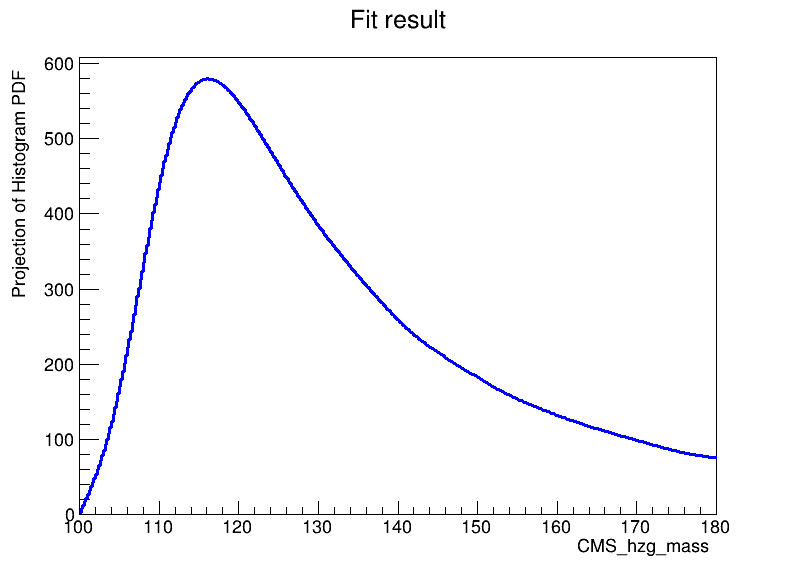

In [108]:
canvas = rt.TCanvas("canvas", "canvas", 800, 600)
frame = H_mass.frame(rt.RooFit.Title("Fit result"))
hist_pdf.plotOn(frame)
#MC["MC_cat0"].plotOn(frame)
#hist_data.plotOn(frame)
#hist_pdf.plotOn(frame)
frame.Draw()
canvas.Draw()



In [109]:
hist_pdf.Print()


RooHistFunc::hist_pdf[ depList=(CMS_hzg_mass) ] = 323.757


# Fit Test

# Plot Data/MC

In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
from pdb import set_trace
import ROOT as rt
import os
from scipy.optimize import curve_fit

Welcome to JupyROOT 6.28/04


In [2]:
datafile_path = "./data_01jet.root"
Corefile_path = "./ZGCoreShape_01jet.root"

#f = rt.TFile("./NAF_SSTest_template.root", "RECREATE")


if os.path.exists(datafile_path):
    f = rt.TFile(datafile_path)
    w = f.Get("w")
    w.Print()
    data = {}
    data_ANF = {}

    data_array = {}
    data_ANF_array = {}

    for cat_i in ["cat0", "cat1", "cat2", "cat3", "allcat"]:
        cat = "data_" + cat_i
        data[cat] = w.data("{}".format(cat))
        data_array[cat] = []

        for i in range(data[cat].numEntries()):
            row = data[cat].get(i)
            data_array[cat].append(row.getRealValue("CMS_hzg_mass"))

        data_array[cat] = pd.DataFrame(data_array[cat], columns=["CMS_hzg_mass"])
        

    for cat_i in ["cat0", "cat1", "cat2", "cat3", "allcat"]:
        cat = "ZG_NAF_" + cat_i
        data_ANF[cat] = w.data("{}".format(cat))
        data_ANF_array[cat] = []

        for i in range(data_ANF[cat].numEntries()):
            row = data_ANF[cat].get(i)
            data_ANF_array[cat].append(row.getRealValue("CMS_hzg_mass"))

        data_ANF_array[cat] = pd.DataFrame(data_ANF_array[cat], columns=["CMS_hzg_mass"])

        data_ANF_array[cat]["weight"] = np.array([len(data_array["data_"+cat_i][(data_array["data_"+cat_i] < 120) & (data_array["data_"+cat_i] > 130)]) / len(data_ANF_array[cat][(data_ANF_array[cat] < 120) & (data_ANF_array[cat] > 130)])]*len(data_ANF_array[cat]))

    H_mass_ANF = w.var("CMS_hzg_mass")

    f.Close()


RooWorkspace(w) workspace contents

variables
---------
(CMS_hzg_mass)

datasets
--------
RooDataSet::data_cat0(CMS_hzg_mass)
RooDataSet::data_cat1(CMS_hzg_mass)
RooDataSet::data_cat2(CMS_hzg_mass)
RooDataSet::data_cat3(CMS_hzg_mass)
RooDataSet::data_allcat(CMS_hzg_mass)
RooDataSet::ZG_NAF_cat0(CMS_hzg_mass)
RooDataSet::ZG_NAF_cat1(CMS_hzg_mass)
RooDataSet::ZG_NAF_cat2(CMS_hzg_mass)
RooDataSet::ZG_NAF_cat3(CMS_hzg_mass)
RooDataSet::ZG_NAF_allcat(CMS_hzg_mass)



In [5]:
data_ANF_array["ZG_NAF_cat3"]

,CMS_hzg_mass,weight
0,169.417831,0.137244
1,108.143661,0.137244
2,133.412994,0.137244
3,107.216782,0.137244
4,118.754051,0.137244
...,...,...
59757,106.858521,0.137244
59758,105.451126,0.137244
59759,114.161636,0.137244
59760,114.653633,0.137244


In [3]:
def DrawPlots(data, MC, name):
    data_hist, bin_edges = np.histogram(data[(data["CMS_hzg_mass"]<120) | (data["CMS_hzg_mass"]>130) & (data["CMS_hzg_mass"]<180)]["CMS_hzg_mass"], bins=80, range=[100, 180])
    MC_hist, bin_edges = np.histogram(MC["CMS_hzg_mass"], bins=80, weights=MC["weight"], range=[100, 180])
    MC_weight_squared, _ = np.histogram(MC["CMS_hzg_mass"], bins=80, weights=MC["weight"]**2, range=[100, 180])
    MC_errors = np.sqrt(MC_weight_squared)

    # fit ratio plot
    ratio = (data_hist / MC_hist)
    ratios_errors = MC_errors/MC_hist

    def linear(x, a, b, c, d, e, f, g):
        return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 +f*x + g
    
    x = bin_edges[:-1]+np.diff(bin_edges)/2
    y = ratio[np.where(((x<120) | (x>130)) & (x>101))]
    # yerr = 1/(data_hist - np.sum(bkg_hists, axis=0))[np.where((x<120) | (x>130))]
    yerr = ratios_errors[np.where(((x<120) | (x>130)) & (x>101))]
    x = x[np.where(((x<120) | (x>130)) & (x>101))]
    popt, pcov = curve_fit(linear, x-100, y, sigma=yerr, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    print(popt, perr)

    # correct NAF
    MC_hist_corr = MC_hist * linear(bin_edges[:-1]+np.diff(bin_edges)/2-100, *popt)
    

    fig, [ax1, ax2, ax3] = plt.subplots(3, 1, gridspec_kw={"height_ratios": [4, 1, 1], "hspace": 0}, sharex='col')

    ax1.set_title(name) 
    hep.histplot(MC_hist_corr, bins=bin_edges, label="NAF", stack=True, histtype="fill", ax=ax1, color='orange') 
    ax1.errorbar(bin_edges[:-1]+np.diff(bin_edges)/2, data_hist, fmt='o', label="Data", yerr=np.sqrt(data_hist), color='k')

    # 绘制误差阴影
    for i in range(bin_edges.shape[0]-1):
        ax1.fill_between([bin_edges[i], bin_edges[i+1]], [MC_hist_corr[i] - MC_errors[i], MC_hist_corr[i] - MC_errors[i]], 
                            [MC_hist_corr[i] + MC_errors[i], MC_hist_corr[i] + MC_errors[i]], color='gray', alpha=0.2)
    ax1.legend(ncol=1, fontsize=16)
    ax1.set_xlim(100, 180)
    ax1.grid()
    ax1.label_outer()

    ax2.errorbar(bin_edges[:-1]+np.diff(bin_edges)/2, ratio, yerr=np.sqrt(data_hist)/data_hist, fmt='o', color='k')
    ax2.plot(bin_edges[:-1]+np.diff(bin_edges)/2, linear(bin_edges[:-1]+np.diff(bin_edges)/2-100, *popt), 'r--')

    ## 绘制误差阴影
    #for i in range(bin_edges.shape[0]-1):
    #    ax2.fill_between([bin_edges[i], bin_edges[i+1]], [1 - ratios_errors[i], 1 - ratios_errors[i]], 
    #                        [1 + ratios_errors[i], 1 + ratios_errors[i]], color='gray', alpha=0.2)
        
    ax2.text(103, 1.45, "pre-fit")
    ax2.axhline(y=1, color='k', linestyle='--')
    ax2.set_ylim(0.2, 1.8)
    ax2.set_xlim(100, 180)
    ax2.set_ylabel("Dat. / Bkg.", fontsize=20)
    ax2.grid()
    ax2.label_outer()

    ratio = (data_hist / MC_hist_corr)
    ax3.errorbar(bin_edges[:-1]+np.diff(bin_edges)/2, ratio, yerr=np.sqrt(data_hist)/data_hist, fmt='o', color='k')
    ax3.text(103, 1.45, "post-fit")
    ax3.axhline(y=1, color='k', linestyle='--')
    ax3.set_ylim(0.2, 1.8)
    ax3.set_xlim(100, 180)
    ax3.set_xlabel("Higgs Mass")
    ax3.set_ylabel("Dat. / Bkg.", fontsize=20)
    ax3.grid()
    ax3.label_outer()

    plt.tight_layout()
    plt.show()
    plt.clf()


/tmp/zewang/ipykernel_1811273/2134100313.py:8: RuntimeWarning: divide by zero encountered in divide
  ratio = (data_hist / MC_hist)
/tmp/zewang/ipykernel_1811273/2134100313.py:9: RuntimeWarning: invalid value encountered in divide
  ratios_errors = MC_errors/MC_hist


[ 7.18518661e-10 -1.89360669e-07  1.95804114e-05 -1.00734838e-03
  2.69278493e-02 -3.50220233e-01  2.64463188e+00] [2.74768571e-11 6.76131967e-09 6.44477996e-07 2.98920671e-05
 6.92528665e-04 7.34116867e-03 2.77132982e-02]


/tmp/zewang/ipykernel_1811273/2134100313.py:42: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bin_edges[:-1]+np.diff(bin_edges)/2, ratio, yerr=np.sqrt(data_hist)/data_hist, fmt='o', color='k')
/tmp/zewang/ipykernel_1811273/2134100313.py:58: RuntimeWarning: divide by zero encountered in divide
  ratio = (data_hist / MC_hist_corr)
/tmp/zewang/ipykernel_1811273/2134100313.py:59: RuntimeWarning: invalid value encountered in divide
  ax3.errorbar(bin_edges[:-1]+np.diff(bin_edges)/2, ratio, yerr=np.sqrt(data_hist)/data_hist, fmt='o', color='k')


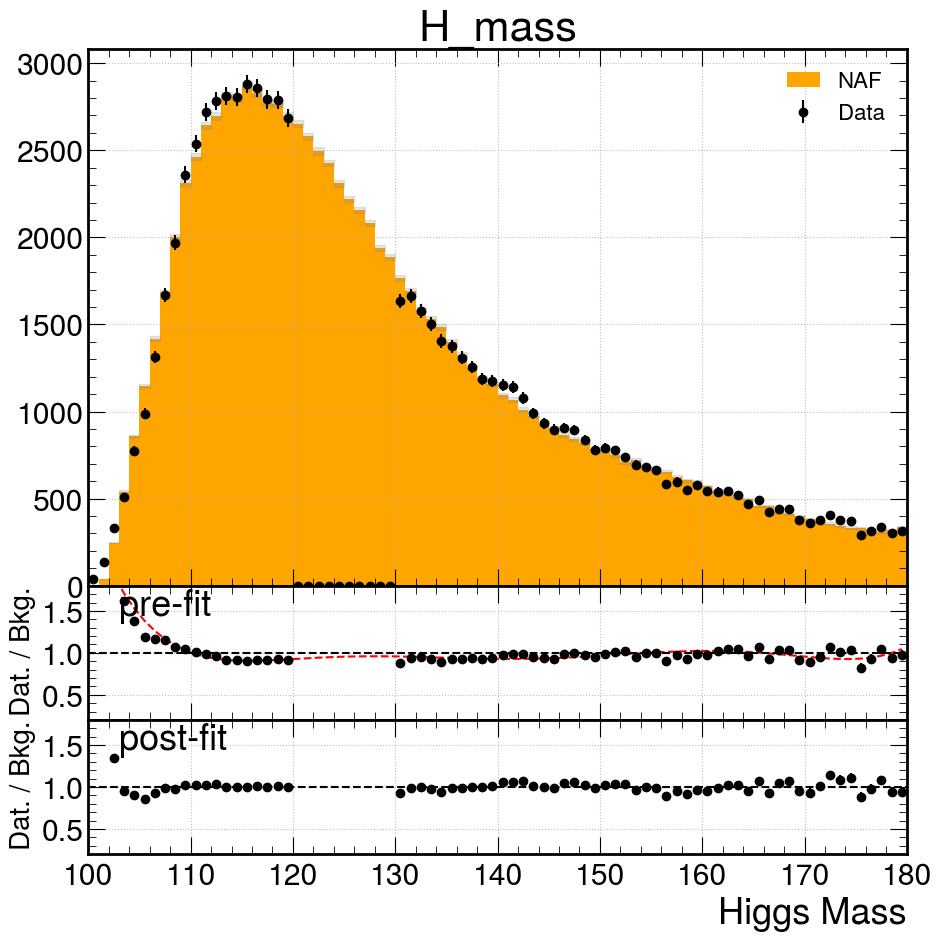

[ 6.06029211e-10 -1.56365842e-07  1.56729660e-05 -7.69660169e-04
  1.91921667e-02 -2.20950541e-01  1.80025645e+00] [3.28036803e-11 7.75214338e-09 7.05244969e-07 3.09993248e-05
 6.74003864e-04 6.58384398e-03 2.23091207e-02]


<Figure size 1000x1000 with 0 Axes>

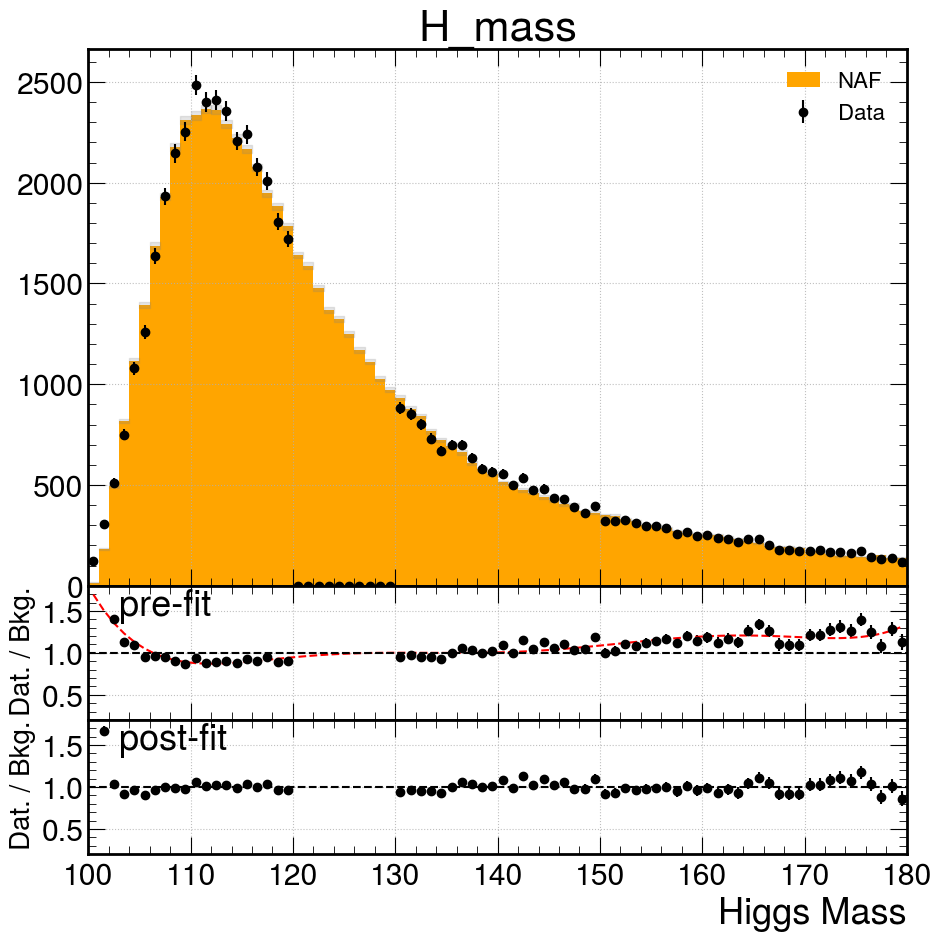

[ 6.92599431e-10 -1.64409718e-07  1.48158554e-05 -6.36249274e-04
  1.33743507e-02 -1.14766705e-01  1.17612513e+00] [4.33745362e-11 9.83949452e-09 8.50600721e-07 3.51088737e-05
 7.06715486e-04 6.24583185e-03 1.84460932e-02]


<Figure size 1000x1000 with 0 Axes>

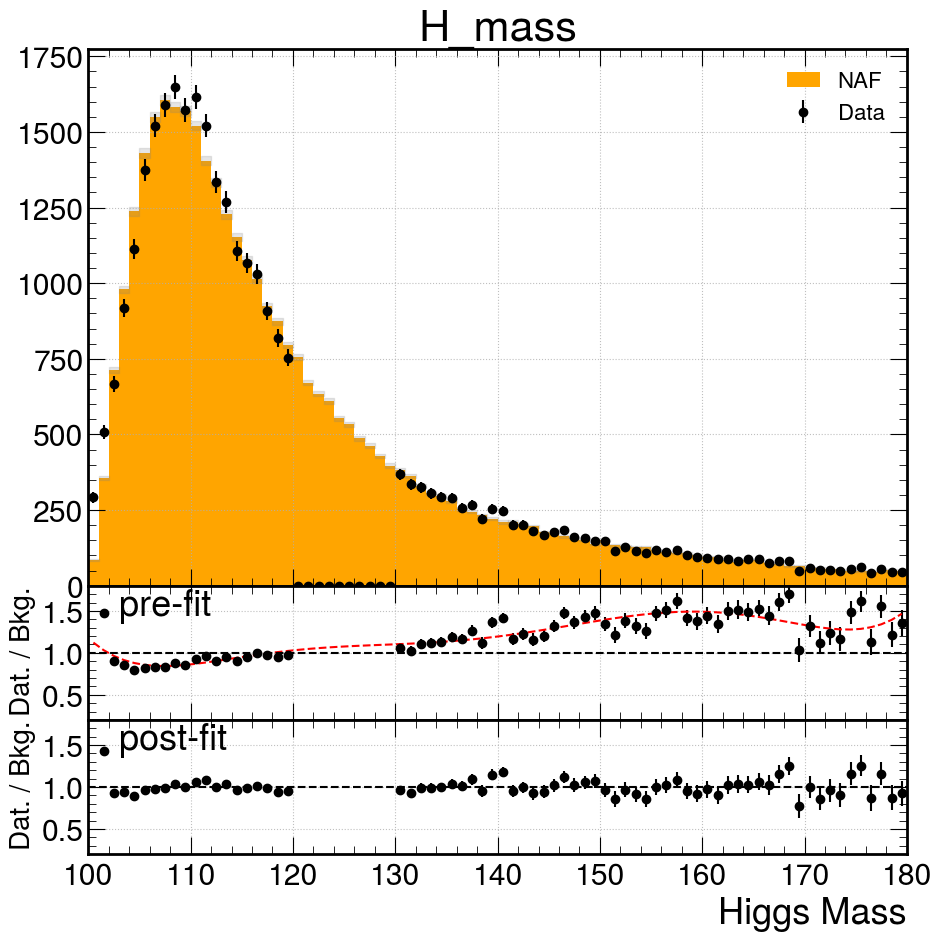

[ 1.06245302e-09 -2.59086724e-07  2.43081362e-05 -1.10673281e-03
  2.52168255e-02 -2.46973757e-01  1.57323858e+00] [8.52538534e-11 1.93348761e-08 1.67046861e-06 6.88086998e-05
 1.37612984e-03 1.19368134e-02 3.35634587e-02]


<Figure size 1000x1000 with 0 Axes>

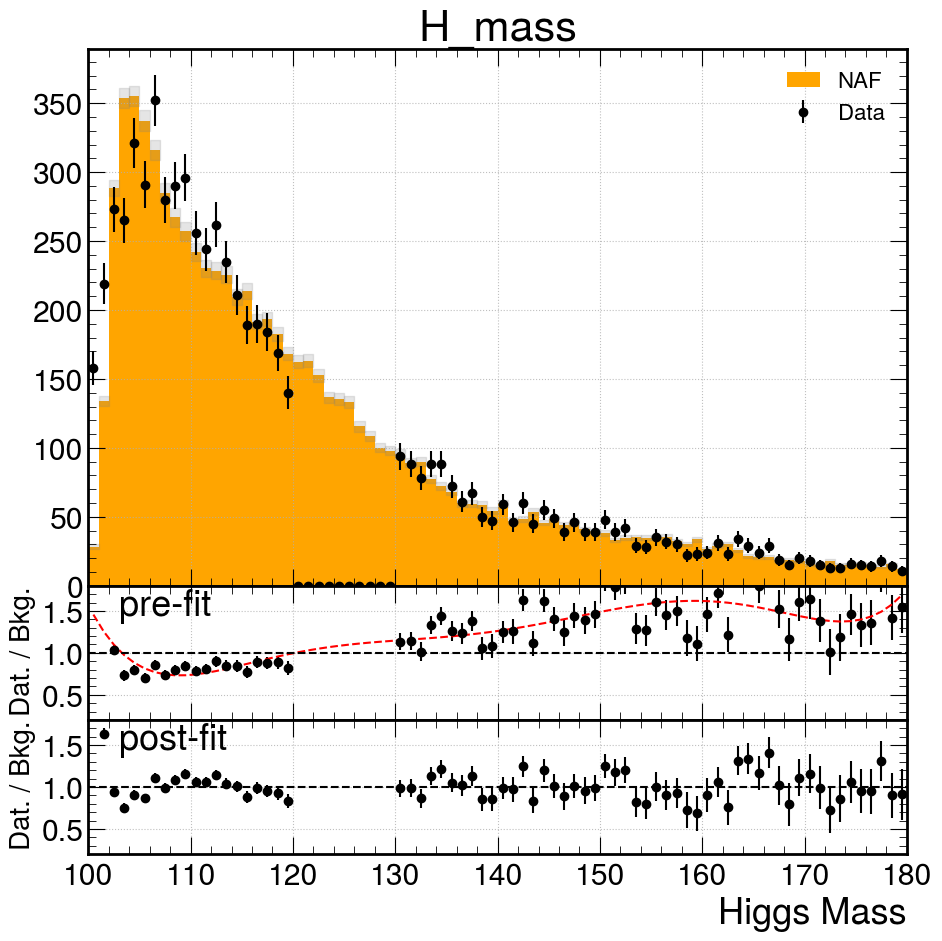

<Figure size 1000x1000 with 0 Axes>

In [8]:
for cat_i in ["cat0", "cat1", "cat2", "cat3"]:
    DrawPlots(data_array["data_" + cat_i], data_ANF_array["ZG_NAF_" + cat_i], "H_mass")

In [5]:
parameters = {"cat0": [7.18518661e-10,-1.89360669e-07,1.95804114e-05,-1.00734838e-03,2.69278493e-02,-3.50220233e-01,2.64463188e+00],
                "cat1": [6.06029211e-10,-1.56365842e-07,1.56729660e-05,-7.69660169e-04,1.91921667e-02,-2.20950541e-01,1.80025645e+00],
                "cat2": [6.92599431e-10,-1.64409718e-07,1.48158554e-05,-6.36249274e-04,1.33743507e-02,-1.14766705e-01,1.17612513e+00],
                "cat3": [1.06245302e-09,-2.59086724e-07,2.43081362e-05,-1.10673281e-03,2.52168255e-02,-2.46973757e-01,1.57323858e+00]
                }

def linear_corr(x, a, b, c, d, e, f, g):
        return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 +f*x + g

hists = {}

for c in parameters.keys():
    cat = "ZG_NAF_" + cat_i
    print(c)
    hists[c] = rt.TH1D("bkg_{}_{}".format("zero_to_one_jet", c), "bkg_{}_{}".format("zero_to_one_jet", c), 80, 100, 180)

    arrays = data_ANF_array[cat].reset_index(drop=True)
    for i in range(0, len(arrays["CMS_hzg_mass"])):
        hists[c].Fill(float(arrays["CMS_hzg_mass"][i]), float(arrays['weight'][i]*linear_corr(arrays["CMS_hzg_mass"][i]-100., parameters["cat0"][0], parameters["cat0"][1], parameters["cat0"][2], parameters["cat0"][3], parameters["cat0"][4], parameters["cat0"][5], parameters["cat0"][6])))

cat0
cat1
cat2
cat3


In [6]:
for c in parameters.keys():
    print(hists[c])
    #hists[c].Write("bkg_{}_{}".format("zero_to_one_jet", c))

Name: bkg_zero_to_one_jet_cat0 Title: bkg_zero_to_one_jet_cat0 NbinsX: 80
Name: bkg_zero_to_one_jet_cat1 Title: bkg_zero_to_one_jet_cat1 NbinsX: 80
Name: bkg_zero_to_one_jet_cat2 Title: bkg_zero_to_one_jet_cat2 NbinsX: 80
Name: bkg_zero_to_one_jet_cat3 Title: bkg_zero_to_one_jet_cat3 NbinsX: 80


In [7]:
f = rt.TFile("./NAF_SSTest_template.root", "RECREATE")

for c in parameters.keys():
    print(hists[c])
    hists[c].Write("bkg_{}_{}".format("zero_to_one_jet", c))

Name: bkg_zero_to_one_jet_cat0 Title: bkg_zero_to_one_jet_cat0 NbinsX: 80
Name: bkg_zero_to_one_jet_cat1 Title: bkg_zero_to_one_jet_cat1 NbinsX: 80
Name: bkg_zero_to_one_jet_cat2 Title: bkg_zero_to_one_jet_cat2 NbinsX: 80
Name: bkg_zero_to_one_jet_cat3 Title: bkg_zero_to_one_jet_cat3 NbinsX: 80
